<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import numpy as np
import gensim
import os
import re

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim

import pandas as pd

import spacy
from spacy.tokenizer import Tokenizer

from collections import Counter

nlp = spacy.load("en_core_web_lg")

import seaborn as sns

unable to import 'smart_open.gcs', disabling that module


In [2]:
def tokenize(doc_series):
    """
    This function returns the tokens of each document in a pandas series as a list.
    """
    
    tokens = []
    
    tokenizer = Tokenizer(nlp.vocab)
    
    STOP_WORDS = nlp.Defaults.stop_words.union(
        ['', ' ', '-', '.', '!', ',', '...', '\n\n', '\n', "it's", "i've", "i'm"]
    )
    
    for doc in tokenizer.pipe(doc_series, batch_size=1000):
        doc_tokens = []
        for token in doc: 
            if token.text.lower() not in STOP_WORDS:
                doc_tokens.append(token.text.lower())
        if doc_tokens:
            doc_tokens.pop(0)
        tokens.append(doc_tokens)
    
    return tokens

def count(docs):
        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
    
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [3]:
df = pd.read_csv('../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
df = df.drop(columns=[
    'id', 'dateAdded', 'dateUpdated', 'asins', 'imageURLs', 'keys', 'manufacturerNumber', 'reviews.date', 'reviews.dateSeen', 
    'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
    'reviews.username', 'sourceURLs'
])
df['reviews.text.tokens'] = tokenize(df['reviews.text'])
df.head()

,name,brand,categories,primaryCategories,manufacturer,reviews.text,reviews.title,reviews.text.tokens
0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,AmazonBasics,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,"[3, item, bad, quality., missing, backup, spri..."
1,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,AmazonBasics,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,"[expensive, way, products, like]"
2,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,AmazonBasics,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,"[price, happy.]"
3,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,AmazonBasics,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,"[brand, batteries, better, price]"
4,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,AmazonBasics,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,"[long, lasting, price, great.]"


In [4]:
count(df['reviews.text.tokens']).head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
18,batteries,3317,4830,1.0,0.015019,0.015019,0.117076
72,great,4339,4807,2.0,0.014947,0.029966,0.153148
7552,tablet,3422,4126,3.0,0.012830,0.042795,0.120782
61,good,3000,3289,4.0,0.010227,0.053022,0.105887
206,use,2726,3062,5.0,0.009521,0.062544,0.096216
39,amazon,2477,3004,6.0,0.009341,0.071884,0.087428
15,price,2559,2681,7.0,0.008336,0.080221,0.090322
639,it.,2356,2489,8.0,0.007739,0.087960,0.083157
1305,easy,2254,2430,9.0,0.007556,0.095516,0.079557
97,love,2181,2341,10.0,0.007279,0.102795,0.076980


In [5]:
id2word = corpora.Dictionary(df['reviews.text.tokens'])

In [6]:
id2word.token2id['good']

59

Looks like it's working.

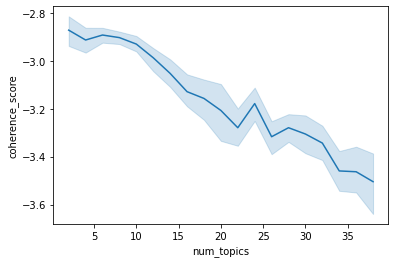

In [8]:
corpus = [id2word.doc2bow(text) for text in df['reviews.text.tokens']]

coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=2, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=10)

topic_coherence = pd.DataFrame.from_records(coherence_values)

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [9]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 6,
                   passes=10,
                   workers=12
                  )

In [10]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.206757 -0.018131       1        1  27.047438
0      0.017047  0.019580       2        1  15.990080
1     -0.057164 -0.035164       3        1  15.660069
4     -0.095658 -0.074352       4        1  14.838966
5     -0.048212  0.127621       5        1  13.821199
3     -0.022769 -0.019555       6        1  12.642249, topic_info=            Term         Freq        Total Category  logprob  loglift
17     batteries  3508.000000  3508.000000  Default  30.0000  30.0000
4334       loves  2074.000000  2074.000000  Default  29.0000  29.0000
7552      tablet  4168.000000  4168.000000  Default  28.0000  28.0000
1375         old  1754.000000  1754.000000  Default  27.0000  27.0000
129   batteries.  1075.000000  1075.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
105        works   165.794693   922.489746   Topic6  -5.5022   0.3518
12          like   212.473343  1884.723877   Topic6  -5.2541  -0.1146
16         price   204.603455  2181.841553   Topic6  -5.2919  -0.2987
59          good   207.542709  2820.446777   Topic6  -5.2776  -0.5412
209          use   149.143845  2917.120117   Topic6  -5.6080  -0.9053

[546 rows x 6 columns], token_table=       Topic      Freq Term
term                       
19002      3  0.872544  $49
11424      1  0.058058    &
11424      2  0.487684    &
11424      3  0.017417    &
11424      4  0.110309    &
...      ...       ...  ...
11493      2  0.014124   yr
11493      3  0.037664   yr
11493      4  0.677959   yr
11493      5  0.207154   yr
11493      6  0.061205   yr

[1435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 6, 4])

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling